# **Carga de datos e importación de librerías**

In [ ]:
import pandas as pd
import re
import math
import networkx as nx
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
import community
from collections import Counter
import community.community_louvain as community_louvain
from wordcloud import WordCloud


df = pd.read_csv("df_limpio_2025.csv")
df.head()

,Unnamed: 0,package,requirement,version
0,0,logsteplib,pyspark,0.0.6
1,1,logsteplib,twine,0.0.6
2,2,logsteplib,build,0.0.6
3,3,birdbrain-python-library-2,black,0.9.40
4,4,birdbrain-python-library-2,flake8,0.9.40


# **Entender los datos**

In [ ]:
valDistintosPackage = df['package'].nunique()

print(f"La cantidad de 'package' distintos es {valDistintosPackage}")

valDistintosCantPackage = df['package'].value_counts()
valDistintosCantRequir =  df['requirement'].value_counts()

print(f"Top 5 (en cantidad de apariciones) de pakage: {valDistintosCantPackage.head(5)}")
print(f"Top 5 (en cantidad de apariciones) de requirements: {valDistintosCantRequir.head(5)}")

La cantidad de 'package' distintos es 36809
Top 5 (en cantidad de apariciones) de pakage: package
acryl-datahub          2344
types-aioboto3          821
types-boto3             820
types-aioboto3-lite     817
types-boto3-lite        813
Name: count, dtype: int64
Top 5 (en cantidad de apariciones) de requirements: requirement
pytest      8081
numpy       6849
requests    5612
pydantic    4780
pandas      4634
Name: count, dtype: int64


# **Limpieza de datos**

In [ ]:
def limpiar(nombre):
  '''
  La función recibe los valores de 'Package' y de 'Package_name' y
  los busca matchear para revisar si hay diferencias entre ambos
  '''
    # Si el valor es nan, no sigue
  if pd.isna(nombre):
      return None
  s = str(nombre).strip().lower()
  s = re.sub(r'\s*\([^)]*\)\s*$', '', s)
  v = re.compile(r'[-_.](?:v?\d[\w.\-!,+]*|r\d+|rev\d+)$', flags=re.I)
  # Se utiliza el while por si existe más de un sufijo
  while v.search(s):
      s = v.sub('', s)

  s = re.sub(r'-[0-9a-f]{6,40}$', '', s, flags=re.I)
  s = re.sub(r'[-_.][ab]\d+$', '', s, flags=re.I)
  cuali = re.compile(
        r'[-_.](?:dev|devel|alpha|beta|rc|pre|post|final|snapshot|nightly|'
        r'unreleased|unofficial|unofficialdev|master|visimus|essex)$',
        flags=re.I
    )
  while cuali.search(s):
      s = cuali.sub('', s)

  s = re.sub(r'[-_.]v?\d[\w.\-+]*\s+(?:alpha|beta|rc|dev|devel)\d*$', '', s, flags=re.I)
  s = re.sub(r'[-_.]+$', '', s)
  s = re.sub(r'^([a-z0-9._-]+)-\1$', r'\1', s)
  return s

# Se aplica la limpieza a 'package' y 'package_name'
df['package_limpio'] = df['package'].apply(limpiar)

# Se observa la cantidad de nulos que hay en cada columna
nulosP = df['package'].isna().sum()

print(f"NaN en package: {nulosP}")



NaN en package: 0


# **Armado del grafo**

In [ ]:
# Limpiar datos
df = df.dropna(subset=['package', 'requirement']).drop_duplicates()

# Crear grafo dirigido
G = nx.DiGraph()

# Añadir edges
G.add_edges_from(df[['package', 'requirement']].itertuples(index=False, name=None))

# Crear versión no dirigida
G_undirected = G.to_undirected()


## **Métricas generales del grafo (cantidad de nodos/aristas)**

In [ ]:
print(f"Nodos en G: {G.number_of_nodes():,}")
print(f"Aristas en G: {G.number_of_edges():,}")

# Se calcula el grado promedio entrada
gradoInProm = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
print("Grado promedio de entrada:", gradoInProm)

# Se calcula el grado promedio salida
gradoOutProm = sum(dict(G.out_degree()).values()) / G.number_of_nodes()
print("Grado promedio de salida:", gradoOutProm)

# Se calcula el grado promedio total
gradoProm = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Grado promedio total:", gradoProm)


Nodos en G: 53,245
Aristas en G: 253,668
Grado promedio de entrada: 4.764165649356747
Grado promedio de salida: 4.764165649356747
Grado promedio total: 9.528331298713494


# **Componentes conexas**

In [ ]:
# Se calcula la cantidad de componentes fuertemente conexas
scc = list(nx.strongly_connected_components(G))
num_scc = len(scc)
print(f"Cantidad de componentes fuertemente conexas: {num_scc}")

# Se calcula la cantidad de componentes dèbilmente conexas
wcc = list(nx.weakly_connected_components(G))
num_wcc = len(wcc)
print(f"Cantidad de componentes débilmente conexas: {num_wcc}")


# Se calcula la cantidad máxima/mínima de nodos para las componentes fuertemente conexas
sizes_scc = [len(c) for c in scc]
max_scc = max(sizes_scc)
min_scc = min(sizes_scc)

print(f"Tamaño máximo de componente fuertemente conexa: {max_scc}")
print(f"Tamaño mínimo de componente fuertemente conexa: {min_scc}")

# Se calcula la cantidad máxima/mínima de nodos para las componentes débilmente conexas
sizes_wcc = [len(c) for c in wcc]
max_wcc = max(sizes_wcc)
min_wcc = min(sizes_wcc)

print(f"Tamaño máximo de componente débilmente conexa: {max_wcc}")
print(f"Tamaño mínimo de componente désbilmente conexa: {min_wcc}")

Cantidad de componentes fuertemente conexas: 52961
Cantidad de componentes débilmente conexas: 315
Tamaño máximo de componente fuertemente conexa: 44
Tamaño mínimo de componente fuertemente conexa: 1
Tamaño máximo de componente débilmente conexa: 52151
Tamaño mínimo de componente désbilmente conexa: 1


# **Importancia de nodos de acuerdo a distintas métricas**

**Dregree centrality**

In [ ]:
# La métrica mide cuántas conexiones totales tiene un nodo con respecto al máximo posible
grad_total = nx.degree_centrality(G)
grad_in    = nx.in_degree_centrality(G)
grad_out   = nx.out_degree_centrality(G)

**Resultados**


Top 5 por Degree centrality:
    nodo  Degree centrality
  pytest           0.134118
   numpy           0.116802
requests           0.100331
pydantic           0.086338
  pandas           0.079220

Bottom 5 por Degree centrality:
         nodo  Degree centrality
       utils4           0.000019
jpegtran-cffi           0.000019
     mido-fix           0.000019
       retrie           0.000019
  mfd-connect           0.000019


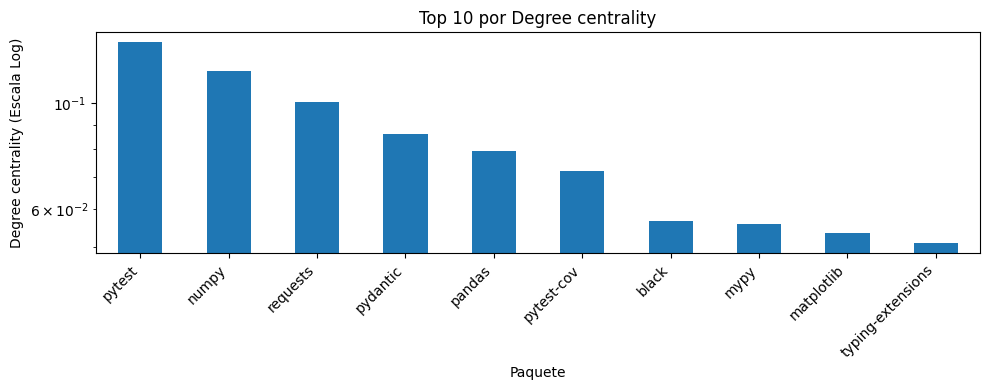

In [ ]:
met = "Degree centrality"
df_deg = (
    pd.Series(grad_total, name=met)
      .reset_index()
      .rename(columns={"index": "nodo"})
      .sort_values(met, ascending=False)
)
topk = df_deg.head(10)
bottomk = df_deg.tail(5)

print(f"\nTop 5 por {met}:")
print(topk[:5].to_string(index=False))

print(f"\nBottom 5 por {met}:")
print(bottomk.to_string(index=False))

# Gráfico
plt.figure(figsize=(10, 4))
ax = topk.set_index("nodo")[met].plot(kind="bar")
ax.set_title(f"Top 10 por {met}")
ax.set_xlabel("Paquete")
ax.set_ylabel(met +" (Escala Log)")
ax.set_yscale("log")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Betweenness centrality**

In [ ]:
# La métrica mide cuántas veces un nodo está en el camino más corto entre otros dos nodos
#bet = nx.betweenness_centrality(G, normalized=True)  --> muy costoso

# Hacemos una aproximación, k es el número de nodos de los que calculamos el camino mínimo
bet = nx.betweenness_centrality(G, k=1500, seed=42)

**Resultados**


Top 5 por Betweenness centrality:
               nodo  Betweenness centrality
            fastapi                0.000053
           datasets                0.000048
langchain-community                0.000040
    mkdocs-material                0.000035
              typer                0.000026

Bottom 5 por Betweenness centrality:
              nodo  Betweenness centrality
           wztools                     0.0
terrakio-admin-api                     0.0
     terrakio-core                     0.0
      terrakio-api                     0.0
  agentic-learning                     0.0


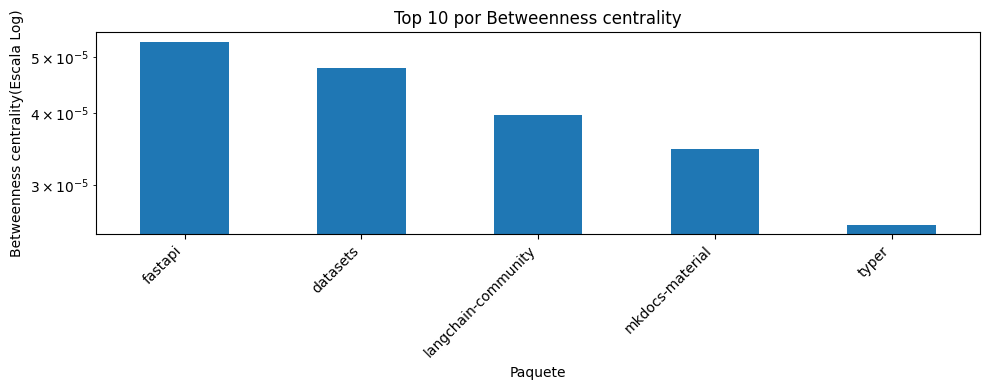

In [ ]:
met = "Betweenness centrality"
df_bet = (
    pd.Series(bet, name=met)
      .reset_index()
      .rename(columns={"index": "nodo"})
      .sort_values(met, ascending=False)
)
topk = df_bet.head(5)
bottomk = df_bet.tail(5)

print(f"\nTop 5 por {met}:")
print(topk[:5].to_string(index=False))

print(f"\nBottom 5 por {met}:")
print(bottomk.to_string(index=False))

# Gráfico
plt.figure(figsize=(10, 4))
ax = topk.set_index("nodo")[met].plot(kind="bar")
ax.set_title(f"Top 10 por {met}")
ax.set_xlabel("Paquete")
ax.set_ylabel(met +"(Escala Log)")
ax.set_yscale("log")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Closeness centrality**

In [ ]:
# La métrica mide el inverso de la suma de las distancias más cortas hacia todos los demás nodos alcanzables
clo = nx.closeness_centrality(G)

**Resultados**

In [ ]:
met = "Closeness centrality"
df_clo = (
    pd.Series(clo, name=met)
      .reset_index()
      .rename(columns={"index": "nodo"})
      .sort_values(met, ascending=False)
)
topk = df_clo.head(10)
bottomk = df_clo.tail(5)

print(f"\nTop 5 por {met}:")
print(topk[:5].to_string(index=False))

print(f"\nBottom 5 por {met}:")
print(bottomk.to_string(index=False))

# Gráfico
plt.figure(figsize=(10, 4))
ax = topk.set_index("nodo")[met].plot(kind="bar")
ax.set_title(f"Top 10 por {met}")
ax.set_xlabel("Paquete")
ax.set_ylabel(met +" (Escala Log)")
ax.set_yscale("log")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Page rank**

In [ ]:
# La métrica mide la popularidad de un nodo considerando cuántos enlaces entran y qué tan importantes son esos nodos
pr  = nx.pagerank(G)

**Resultados**

In [ ]:
met = "Page rank"
df_pr = (
    pd.Series(pr, name=met)
      .reset_index()
      .rename(columns={"index": "nodo"})
      .sort_values(met, ascending=False)
)
topk = df_pr.head(10)
bottomk = df_pr.tail(5)

print(f"\nTop 5 por {met}:")
print(topk[:5].to_string(index=False))

print(f"\nBottom 5 por {met}:")
print(bottomk.to_string(index=False))

# Gráfico
plt.figure(figsize=(10, 4))
ax = topk.set_index("nodo")[met].plot(kind="bar")
ax.set_title(f"Top 10 por {met}")
ax.set_xlabel("Paquete")
ax.set_ylabel(met +" (Escala Log)")
ax.set_yscale("log")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# **Creación de subgrafos**

**Por grado de entrada**

In [ ]:
#Se realiza un subgrafo con aquellos nodos que tienen su grado de entrada mayor a los distintos umbrales: 0, 1, 2, 5, 10, 500

in_deg_map = dict(G.in_degree())

for i in [500, 10, 5, 2, 1, 0]:
    print('mayor a', i)
    nodos_filtrados = {n for n, d in in_deg_map.items() if d > i}
    print("nodos seleccionados:", len(nodos_filtrados))

    sub_B = df[df['package'].isin(nodos_filtrados) & df['requirement'].isin(nodos_filtrados)].copy()
    sub_B = sub_B.rename(columns={'package': 'source', 'requirement': 'target'})[['source', 'target']]
    sub_B.to_csv(f'in_degree_mayor_que_{i}_induced.csv', index=False)
    print("aristas (opción B, inducido):", len(sub_B))

    # Exporto a Gephi solo el de grado mayor a 500
    if i==500:
      subG_degree_in = G.subgraph(nodos_filtrados).copy()

      # Agregar atributos útiles para Gephi
      for n in subG_degree_in.nodes():
          subG_degree_in.nodes[n]["in_degree"] = G.in_degree(n)
          subG_degree_in.nodes[n]["out_degree"] = G.out_degree(n)
          subG_degree_in.nodes[n]["degree"] = G.degree(n)

      out_name = f"subgrafo_in_degree_mayor_que_{i}.gexf"
      nx.write_gexf(subG_degree_in, out_name)
      print(f"Archivo exportado: {out_name}")

mayor a 500
nodos seleccionados: 65
aristas (opción B, inducido): 41
Archivo exportado: subgrafo_in_degree_mayor_que_500.gexf
mayor a 10
nodos seleccionados: 1915
aristas (opción B, inducido): 5387
mayor a 5
nodos seleccionados: 3295
aristas (opción B, inducido): 10799
mayor a 2
nodos seleccionados: 6920
aristas (opción B, inducido): 20837
mayor a 1
nodos seleccionados: 11437
aristas (opción B, inducido): 33346
mayor a 0
nodos seleccionados: 30090
aristas (opción B, inducido): 70425


Guardo los nodos sin dependencias para análisis.

In [ ]:
# Exportar lista de nodos con in_degree = 0
nodos_sin_dependencias = [n for n, d in in_deg_map.items() if d == 0]
print("\nNodos con in_degree = 0:", len(nodos_sin_dependencias))

with open("nodos_con_in_degree_0.txt", "w", encoding="utf-8") as f:
  for n in nodos_sin_dependencias:
      f.write(n + "\n")

print("Archivo exportado: nodos_con_in_degree_0.txt")


Nodos con in_degree = 0: 57524
Archivo exportado: nodos_con_in_degree_0.txt


**Por page rank**

In [ ]:
# Subgrafo tal que se queda únicamente con el 5% de los nodos con mayor valor de Page Rank

umbral = pd.Series(pr).quantile(0.95)
top_nodos_pr = [n for n, v in pr.items() if v >= umbral]

G_core_pr = G.subgraph(top_nodos_pr).copy()
print(f"Nodos seleccionados: {len(G_core_pr)}")

for n in G_core_pr.nodes():
    G_core_pr.nodes[n]["pagerank"] = pr[n]
    G_core_pr.nodes[n]["in_degree"] = G.in_degree(n)

nx.write_gexf(G_core_pr, "grafo_pagerank.gexf")

**Por Betweenness Centrality**

In [ ]:
# Subgrafo con los 300 nodos con mayor valor de la métrica Betweenness Centrality
bet_series = pd.Series(bet)

top_n = 300
top_nodes = set(bet_series.sort_values(ascending=False).head(top_n).index)

subG_bet = G.subgraph(top_nodes).copy()

# Agregar atributos al subgrafo
for n in subG_bet.nodes():
    subG_bet.nodes[n]["betweenness_global"] = bet[n]
    subG_bet.nodes[n]["degree_in"] = in_deg[n]
    subG_bet.nodes[n]["pagerank"] = pr[n]

print(f"Subgrafo: {subG_bet.number_of_nodes()} nodos, {subG_bet.number_of_edges()} aristas")
nx.write_gexf(subG_bet, f"subgrafo_top{top_n}_betweenness.gexf")

# **Comunidades**


In [ ]:
# Se encuentra y devuelve la partición 'óptima' según Louvain
partition = community_louvain.best_partition(G_undirected, random_state=42)

# Se calcula la modularidad
modularity = community_louvain.modularity(partition, G_undirected)

# Se realizan estadísticas de comunidades
num_communities = len(set(partition.values()))
community_sizes = pd.Series(partition.values()).value_counts()

print(f"\n--- RESULTADOS ---")
print(f"Nodos: {G_undirected.number_of_nodes()}")
print(f"Aristas: {G_undirected.number_of_edges()}")
print(f"Comunidades: {num_communities}")
print(f"Modularidad: {modularity:.4f}")
print(f"Comunidad más grande: {community_sizes.max()} nodos")

degrees = dict(G_undirected.degree())
pagerank = nx.pagerank(G_undirected, max_iter=50)

# Se exporta el grafo con los atributos
nx.set_node_attributes(G_undirected, partition, 'community')
nx.set_node_attributes(G_undirected, degrees, 'degree')
nx.set_node_attributes(G_undirected, pagerank, 'pagerank')

nx.write_gexf(G_undirected, "comunidades_completo.gexf")

# Se comvierte a CSV
df_summary = pd.DataFrame({
    'Métrica': ['Nodos', 'Aristas', 'Comunidades', 'Modularidad'],
    'Valor': [G_undirected.number_of_nodes(), G_undirected.number_of_edges(), num_communities, modularity]
})
df_summary.to_csv('resumen_red.csv', index=False)

# **Métricas y subgrafos a partir del grafo no dirigido (G_undirected)**

**Por grado mínimo**

In [ ]:
# Se realiza un subgrafo únicamente con aquellos nodos que tienen su grado mayor o igual a 45
min_degree = 45
nodes_to_keep = [n for n in G_undirected.nodes() if G_undirected.degree(n) >= min_degree]
G_filtered = G_undirected.subgraph(nodes_to_keep).copy()

print(f"Nodos originales: {G_undirected.number_of_nodes()}")
print(f"Nodos filtrados: {G_filtered.number_of_nodes()}")

# Se recalcular las comunidades en el subgrafo
partition_filt = community_louvain.best_partition(G_filtered, random_state=42)
modularity_45 = community_louvain.modularity(partition_filt, G_filtered)
degrees_45 = dict(G_filtered.degree())
pagerank_45 = nx.pagerank(G_filtered, max_iter=50)

# Se exporta el filtrado
nx.set_node_attributes(G_filtered, partition_filt, 'community')
nx.set_node_attributes(G_filtered, degrees_45, 'degree')
nx.set_node_attributes(G_filtered, pagerank_45, 'pagerank')

print("modularidad:", modularity_45)
print("nodos:", G_filtered.number_of_nodes())
print("aristas:", G_filtered.number_of_edges())
print("comunidades:", len(set(partition_filt.values())))
print("densidad:", nx.density(G_filtered))

nx.write_gexf(G_filtered, "red_python_filtrada_g45.gexf")

**Por PageRank**

In [ ]:
# Se realiza un subgrafo únicamente con los top 200 nodos según PageRank
top_n = 200
pagerank_full = nx.pagerank(G_undirected, max_iter=50)
top_nodos = sorted(pagerank_full.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_nodos_lista = [n[0] for n in top_nodos]

G_top_pr = G_undirected.subgraph(top_nodos_lista).copy()

print(f"Nodos originales: {G_undirected.number_of_nodes()}")
print(f"Nodos filtrados: {G_top_pr.number_of_nodes()}")

# Recalcular comunidades en el subgrafo
partition = community_louvain.best_partition(G_top_pr, random_state=42)
modularity = community_louvain.modularity(partition, G_top_pr)
degrees = dict(G_top_pr.degree())
pagerank = nx.pagerank(G_top_pr, max_iter=50)

# Exportar el filtrado
nx.set_node_attributes(G_top_pr, partition, 'community')
nx.set_node_attributes(G_top_pr, degrees, 'degree')
nx.set_node_attributes(G_top_pr, pagerank, 'pagerank')

nx.write_gexf(G_top_pr, "subgrafo_pagerank_200.gexf")

**Por 3 comunidades más grandes**

In [ ]:
top_3_communities = community_sizes.head(3).index.tolist()

print("Tamaños de comunidades:")
print(community_sizes.head(10))
print(f"\nTop 3 comunidades: {top_3_communities}")
print(f"Tamaños: {[community_sizes[c] for c in top_3_communities]}")

# Se filtran aquellos nodos que pertenecen a esas 3 comunidades
nodes_top3 = [node for node, comm in partition.items() if comm in top_3_communities]

print(f"\nNodos en top 3 comunidades: {len(nodes_top3)}")

# Se crea el subgrafo
G_top3 = G_undirected.subgraph(nodes_top3).copy()

print(f"Aristas en subgrafo: {G_top3.number_of_edges()}")

# Se recalculan las métricas para el subgrafo
partition_top3 = {n: partition[n] for n in G_top3.nodes()}

# ---- MODULARIDAD  ----
try:
    modularity_top3 = community_louvain.modularity(partition_top3, G_top3)
except ValueError:
    print("⚠ El subgrafo no tiene aristas. La modularidad no se puede calcular.")
    modularity_top3 = None

# ---- DEGREE ----
degrees_top3 = dict(G_top3.degree())

# ---- PAGERANK  ----
try:
    pagerank_top3 = nx.pagerank(G_top3, max_iter=50)
except Exception:
    print("⚠ PageRank no puede calcularse en un grafo sin aristas.")
    pagerank_top3 = {n: 0 for n in G_top3.nodes()}

print(f"Modularidad top 3: {modularity_top3}")

# Se añaden los atributos
nx.set_node_attributes(G_top3, partition_top3, 'community')
nx.set_node_attributes(G_top3, degrees_top3, 'degree')
nx.set_node_attributes(G_top3, pagerank_top3, 'pagerank')

# Se convierte a csv
df_top3 = pd.DataFrame({
    'Comunidad': top_3_communities,
    'Tamaño': [community_sizes[c] for c in top_3_communities],
    'Porcentaje': [100 * community_sizes[c] / len(partition) for c in top_3_communities]
})
print("\n--- TOP 3 COMUNIDADES ---")
print(df_top3)
df_top3.to_csv('top3_comunidades_resumen.csv', index=False)

# Se exporta para Gephi
nx.write_gexf(G_top3, "top3_comunidades.gexf")


**Por la comunidad más grande**

In [ ]:
top_1_communities = community_sizes.head(1).index.tolist()

# Se filtran aquellos nodos que pertenecen a esa comunidad
nodes_top1 = [node for node, comm in partition.items() if comm in top_1_communities]

print(f"\nNodos en top 1 comunidades: {len(nodes_top1)}")

# Se crea el subgrafo
G_top1 = G_undirected.subgraph(nodes_top1).copy()

print(f"Aristas en subgrafo: {G_top1.number_of_edges()}")

# Se recalculan las métricas para el subgrafo
partition_top1 = {n: partition[n] for n in G_top1.nodes()}

# ---- MODULARIDAD ----
try:
    modularity_top1 = community_louvain.modularity(partition_top1, G_top1)
except ValueError:
    print("⚠ El subgrafo no tiene aristas. La modularidad no se puede calcular.")
    modularity_top1 = None

# ---- DEGREE ----
degrees_top1 = dict(G_top1.degree())

# ---- PAGERANK ----
try:
    pagerank_top1 = nx.pagerank(G_top1, max_iter=50)
except Exception:
    print("⚠ PageRank no puede calcularse en un grafo sin aristas.")
    pagerank_top1 = {n: 0 for n in G_top1.nodes()}

if modularity_top1 is not None:
    print(f"Modularidad top 1: {modularity_top1:.4f}")
else:
    print("Modularidad top 1: None")

# Se añaden los atributos
nx.set_node_attributes(G_top1, partition_top1, 'community')
nx.set_node_attributes(G_top1, degrees_top1, 'degree')
nx.set_node_attributes(G_top1, pagerank_top1, 'pagerank')

# Se convierte a csv
df_top1 = pd.DataFrame({
    'Comunidad': top_1_communities,
    'Tamaño': [community_sizes[c] for c in top_1_communities],
    'Porcentaje': [100 * community_sizes[c] / len(partition) for c in top_1_communities]
})
print("\n--- TOP 1 COMUNIDADES ---")
print(df_top1)

df_top1.to_csv('top1_comunidades_resumen.csv', index=False)


**Por las comunidades más importantes según PageRank**

In [ ]:
# A diferencia del otro subgrafo calculado anteriormente, en este se calcula el PageRank para cada nodo, después se suma para obtener el
# 'PageRank total' por comunidad y luego se filtran las top N comunidades.

# Se calcula la importancia de las comunidades según PageRank
community_imp = {}
community_sizes = {}

for nodo, comm in partition.items():
    # Se suma el PageRank de todos los nodos en cada comunidad
    if comm not in community_imp:
        community_imp[comm] = 0
        community_sizes[comm] = 0
    community_imp[comm] += pagerank_full[nodo]
    community_sizes[comm] += 1

# Se ordenan según este criterio y se selecciona la comunidad top 1
top_n_com = 1
top_com = sorted(community_imp.items(), key=lambda x: x[1], reverse=True)[:top_n_com]
top_com_ids = [c[0] for c in top_com]

print(f"Top {top_n_com} comunidades por importancia (PageRank)")
for i, (comm, imp) in enumerate(top_com, 1):
    size = community_sizes[comm]
    pagerank_prom = imp / size
    print(f"{i}. Comunidad {comm}:")
    print(f"   - Tamaño: {size} nodos")
    print(f"   - PageRank total: {imp:.6f}")
    print(f"   - PageRank promedio: {pagerank_prom:.6f}")

# Se filtran los nodos de esa comunidad
nodes_top_communities = [node for node, comm in partition.items() if comm in top_com_ids]

print(f"Nodos en top {top_n_com} comunidades: {len(nodes_top_communities)}")

# Se crea el subgrafo
G_top_comm = G_undirected.subgraph(nodes_top_communities).copy()

print(f"Subgrafo top {top_n_com} comunidades ")
print(f"Nodos: {G_top_comm.number_of_nodes()}")
print(f"Aristas: {G_top_comm.number_of_edges()}")

# Se calculan métricas sobre este subgrafo
partition_top = {n: partition[n] for n in G_top_comm.nodes()}
modularity_top = community_louvain.modularity(partition_top, G_top_comm)
degrees_top = dict(G_top_comm.degree())
pagerank_top = nx.pagerank(G_top_comm, max_iter=50)

print(f"Modularidad: {modularity_top:.4f}")

# Se añaden los atributos a este subgrafo
nx.set_node_attributes(G_top_comm, partition_top, 'community')
nx.set_node_attributes(G_top_comm, degrees_top, 'degree')
nx.set_node_attributes(G_top_comm, pagerank_top, 'pagerank')
pagerank_full_subgrafo = {n: pagerank_full[n] for n in G_top_comm.nodes()}
nx.set_node_attributes(G_top_comm, pagerank_full_subgrafo, 'pagerank_full')

# Se exporta para Gephi
filename = f"top{top_n_com}_comunidades_importantes.gexf"
nx.write_gexf(G_top_comm, filename)

# Se genera un resumen de las comunidades
df_communities = pd.DataFrame({
    'Comunidad': top_com_ids,
    'Tamaño': [community_sizes[c] for c in top_com_ids],
    'PageRank_Total': [community_imp[c] for c in top_com_ids],
    'PageRank_Promedio': [community_imp[c] / community_sizes[c] for c in top_com_ids],
    'Porcentaje_Nodos': [100 * community_sizes[c] /len(partition) for c in top_com_ids]
})

df_communities = df_communities.sort_values('PageRank_Total', ascending=False)
df_communities.to_csv(f'top{top_n_com}_comunidades_importantes.csv', index=False)
print(f"✓ Exportado: top{top_n_com}_comunidades_importantes.csv")

# Se exportan
df_nodes = pd.DataFrame({
    'library': list(G_top_comm.nodes()),
    'community': [partition_top[n] for n in G_top_comm.nodes()],
    'degree': [degrees_top[n] for n in G_top_comm.nodes()],
    'pagerank_subgrafo': [pagerank_top[n] for n in G_top_comm.nodes()],
    'pagerank_completo': [pagerank_full[n] for n in G_top_comm.nodes()]
})
df_nodes = df_nodes.sort_values('pagerank_completo', ascending=False)
df_nodes.to_csv(f'nodos_top{top_n_com}_comunidades.csv', index=False)
print(f"\n✓ Exportado: nodos_top{top_n_com}_comunidades.csv")

# Se realiza un resumen de todo
df_summary = pd.DataFrame({
    'Métrica': ['Nodos_Totales', 'Aristas_Totales', 'Comunidades', 'Modularidad', 'Densidad'],
    'Valor': [
        G_top_comm.number_of_nodes(),
        G_top_comm.number_of_edges(),
        len(top_com_ids),
        modularity_top,
        nx.density(G_top_comm)
    ]
})
df_summary.to_csv(f'resumen_top{top_n_com}_comunidades.csv', index=False)

# **WordClouds**

In [ ]:
import pyarrow.parquet as pq
table = pq.read_table("311025.parquet")
red_nueva = table.to_pandas()

def CalcularWordCloud(nodos, titulo, i, pagerank, save=False):
    descripciones = red_nueva[red_nueva['name'].isin(nodos)]['summary']

    all_words = []

    for d in descripciones:
        if d == None: continue
        lower = d.lower()
        words = re.split(r"[ ,.-:(){\n}]+", lower)
        all_words += list(filter(None, words))


    counts = Counter(all_words)

    palabras_bloqueadas = ['for', 'a', 'library', 'and', 'the', 'package', 'python',
                           'in', 'to', 'with', 'of', 'as', 'is', 'it','on', 'an',
                           'that', '-', 'your', '\n*' 'which', 'you', 'by', 'into',
                           'or', 'from', 'module', 'this', 'simple', 'fast', 'module']


    count_filtered = {key:val for key, val in counts.items() if key not in palabras_bloqueadas}

    top_nodes = list(reversed(sorted(nodos, key=lambda n: pagerank[n], reverse=True)[:10]))
    top_nodes_pageRank = [pagerank[n] for n in top_nodes]


    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          random_state=42
                          ).generate_from_frequencies(count_filtered)


    fig, ax = plt.subplots(1,2,figsize=(16,9), gridspec_kw={'width_ratios': [2, 1]})
    ax[0].imshow(wordcloud, interpolation='bilinear')
    ax[0].axis('off')
    ax[1].barh(top_nodes, top_nodes_pageRank,
               facecolor=[0.1,.6,.6,.5], animated=True)
    ax[1].tick_params(axis='both', labelsize=20)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].get_xaxis().set_ticks([])
    fig.suptitle(titulo, size=24)
    fig.tight_layout()
    if save:
      plt.savefig(f'imagenes/WordCloudComunidad{i}MasGrandeVieja')
    else:
      plt.show()

In [ ]:
N_comunidades = 10

partition = community_louvain.best_partition(G_undirected, resolution=.65, random_state=42)
community_sizes = pd.Series(partition).value_counts()
top_communities = community_sizes.head(N_comunidades).index.tolist()

In [ ]:
i = 1
for top_comm in top_communities:
    nodes_comm = [node for node, comm in partition.items() if comm == top_comm ]
    titulo = f"Word Cloud y PageRank de {i}° Comunidad Más Grande de Red "
    CalcularWordCloud(nodes_comm, titulo, i, pagerank_full)
    i += 1